In [1]:
import skorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [2]:
from sine_data import train_dataset, valid_dataset

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import insp

In [4]:
import visdom
vis = visdom.Visdom()

In [5]:



X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [57]:
class InhCWRNN(nn.Module):
    """simply learning sine parameters from var(sister module)"""
    def __init__(self, input_dim, output_dim, num_modules, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        
        self.input_period = nn.Linear(input_dim, output_dim)
        self.hidden_period = nn.Linear(output_dim, output_dim, bias=False)
        
        self.module_shifts = nn.Parameter(torch.zeros(num_modules))
        
        self.f_mod = nn.Tanh()        
        
    def step(self, ti, xi, h):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        module_acts = acts.view(-1, self.num_modules, module_size)
        
        acts_period = self.f_mod(self.input_period(xi) + self.hidden_period(h))
        module_acts_period = acts.view(-1, self.num_modules, module_size)
        
        # use variance as indicator for surprisal and, hence, update rate
        suprisal = module_acts_period.var(-1, keepdim=True)
        module_periods = surprisal
                
        # y=(sin(x)+1)/2 so we y is in [0;1]
        gate = (torch.sin(ti * module_periods + self.module_shifts) + 1) / 2
        #gate = gate.view(1, -1, 1).expand_as(module_acts).contiguous()
        gate = gate.view(-1, self.output_dim)
                
        y = (1 - gate) * acts + gate * h
        
        return y, y, module_periods
        
    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        ps = []
        for ti in range(t):
            xi = x[:, ti]
            yi, h, p = self.step(ti, xi, h)     
            ys.append(yi)
            ps.append(p.squeeze(-1))
        return torch.stack(ys, dim=1), h, torch.stack(ps, dim=1)

In [93]:
class InhCWRNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        
        self.input_rec = nn.Linear(input_dim, input_dim * num_modules)
        self.hidden_rec = nn.Linear(input_dim * num_modules, input_dim * num_modules, bias=False)
        
        self.module_shifts = nn.Parameter(torch.zeros(num_modules))
        
        self.f_mod = nn.Tanh()
        
    def step(self, ti, xi, h, x_pred):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        module_acts = acts.view(-1, self.num_modules, module_size)
        
        # predict x_{t+1}, store for next step
        acts_rec = self.f_mod(self.input_rec(xi) + self.hidden_rec(x_pred))
        module_acts_rec = acts_rec.view(-1, self.num_modules, self.input_dim)
        
        # compare last prediction with current x, compute surprisal from that
        module_x_pred = x_pred.view(-1, self.num_modules, self.input_dim)
        surprisal = F.log_softmax(module_x_pred) * xi.unsqueeze(1).expand_as(module_acts_rec)
        # compute the mean surprisal for each module
        mean_surprisal = surprisal.mean(-1)
        # use mean surprisal to drive the periodicity of the module's gate
        module_periods = mean_surprisal
                
        # y=(sin(x)+1)/2 so we y is in [0;1]
        gate = (torch.sin(ti * module_periods + self.module_shifts) + 1) / 2
        gate = gate.unsqueeze(-1).expand_as(module_acts).contiguous()
        gate = gate.view(-1, self.output_dim)
                
        y = (1 - gate) * acts + gate * h
        
        return y, y, acts_rec, module_periods
        
    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        x_pred = Variable(torch.zeros(self.input_dim * self.num_modules))
        ps = []
        for ti in range(t):
            xi = x[:, ti]
            yi, h, x_pred, p = self.step(ti, xi, h, x_pred) 
            ys.append(yi)
            ps.append(p.squeeze(-1))
        return torch.stack(ys, dim=1), h, torch.stack(ps, dim=1)

In [94]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [95]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_modules=8):
        super().__init__()
        
        self.rnn = InhCWRNN(1, num_hidden, num_modules)
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0, p0 = self.rnn(x)
        
        vis.heatmap(l0[0].data.numpy(), win="act")
        vis.heatmap(p0[0].data.numpy(), win="periods")
        vis.heatmap(self.rnn.module_shifts.data.numpy().reshape(1, -1), win="shifts")

        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [96]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

### exp inhibition

In [100]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optim=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
            )

In [101]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0320        0.4681  0.9785
      2        0.4486        0.2651  1.0226
      3        0.2505        0.1672  0.9924
      4        0.1708        0.1100  1.0581
      5        0.1240        0.1098  1.0639
      6        0.1240        0.1259  0.9962
      7        0.1364        0.1050  1.0010
      8        0.1144        0.0611  1.0872
      9        0.0712        0.0315  1.1331
     10        0.0418        0.0283  0.9800
     11        0.0375        0.0366  1.1288
     12        0.0433        0.0397  1.9523
     13        0.0440        0.0364  1.4621
     14        0.0389        0.0340  1.5090
     15        0.0356        0.0358  1.4067
     16        0.0374        0.0377  0.9712
     17        0.0395        0.0340  1.2149
     18        0.0363        0.0253  1.7223
     19        0.0281        0.0167  1.1479
     20        0.0202        0.0124

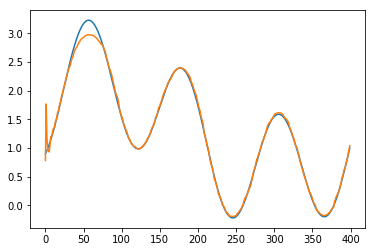

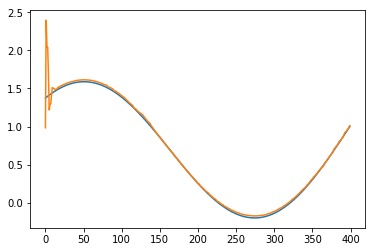

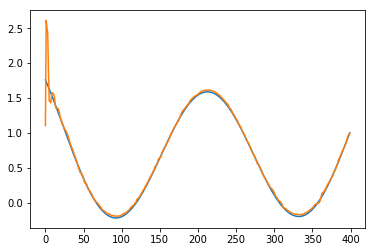

In [102]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])